In [1]:
import numpy as np
import pandas as pd

file_name = "../data/validated_output/7_num_joints/0.1_beta/right_7_1000000_filled.csv"
original_data_file_name = "../data/input/right_joint_states/right_7_3556224_1548650769.0.csv"

output_dir = "../results/"
JOINT_NAMES = ['s0','s1','e0','e1','w0','w1','w2']
JOINT_LIMITS = {
    's0': [-1.7016, 1.7016],
    's1': [-2.147, 1.047],
    'e0': [-3.0541, 3.0541],
    'e1': [-0.05, 2.618],
    'w0': [-3.059, 3.059],
    'w1': [-1.5707, 2.094],
    'w2': [-3.059, 3.059]
}

collisionKey = 'inCollision'
HEADERS = ['right_' + joint_name for joint_name in JOINT_NAMES]
headers_w_collision = HEADERS.copy()
headers_w_collision.append('inCollision')

data = pd.read_csv(file_name, usecols=headers_w_collision)

for joint_name in JOINT_NAMES:
    header = 'right_' + joint_name
    joint_value = data[header]
    print("Statistics for %s" % joint_name)
    print("The maximum is: %s;" % np.max(joint_value))
    print("The minimum is: %s;" % np.min(joint_value))
    print("The range is: %s;" % (np.max(joint_value) - np.min(joint_value)))
    
    print("The mean is: %s;" % np.mean(joint_value))
    print("The median is: %s;" % np.median(joint_value))
    print("The joint limits for the range is: %s" % JOINT_LIMITS[joint_name])
    print("-----------------")

Statistics for s0
The maximum is: 2.1401691436767583;
The minimum is: -2.0024375915527344;
The range is: 4.142606735229492;
The mean is: -0.11965445530864596;
The median is: -0.14013201743364334;
The joint limits for the range is: [-1.7016, 1.7016]
-----------------
Statistics for s1
The maximum is: 1.28801429271698;
The minimum is: -3.027709007263184;
The range is: 4.315723299980164;
The mean is: -0.25453887460154945;
The median is: -0.22952058911323547;
The joint limits for the range is: [-2.147, 1.047]
-----------------
Statistics for e0
The maximum is: 3.2014493942260738;
The minimum is: -3.20668363571167;
The range is: 6.408133029937744;
The mean is: -0.14015423087394238;
The median is: -0.24073155224323273;
The joint limits for the range is: [-3.0541, 3.0541]
-----------------
Statistics for e1
The maximum is: 2.827805280685425;
The minimum is: -0.11942684650421145;
The range is: 2.9472321271896362;
The mean is: 1.1981439587553442;
The median is: 1.1664502620697021;
The joint lim

In [2]:
# Histogram plot for generated data;

import matplotlib.pyplot as plt

i = 1

fig = plt.figure(figsize=(10,10))
for joint_name in JOINT_NAMES:
    plt.subplot(4,2,i)
    header = 'right_' + joint_name
    joint_value = data[header]
    i += 1
    
    plt.hist([joint_value], density=True, histtype='bar', color = ['blue'], bins = 100, label=['generated_values'])
    plt.axvline(x=JOINT_LIMITS[joint_name][0], color='r', linewidth=1)
    plt.axvline(x=JOINT_LIMITS[joint_name][1], color='r', linewidth=1)
    plt.legend()
    
    # Add labels
    plt.title('Histogram for joint: %s' % joint_name)
    plt.xlabel('Joint configs')
    plt.ylabel('Frequency')
    plt.axis('off')
    # plt.savefig(output_dir + joint_name + '.png')

plt.show()

<Figure size 1000x1000 with 7 Axes>

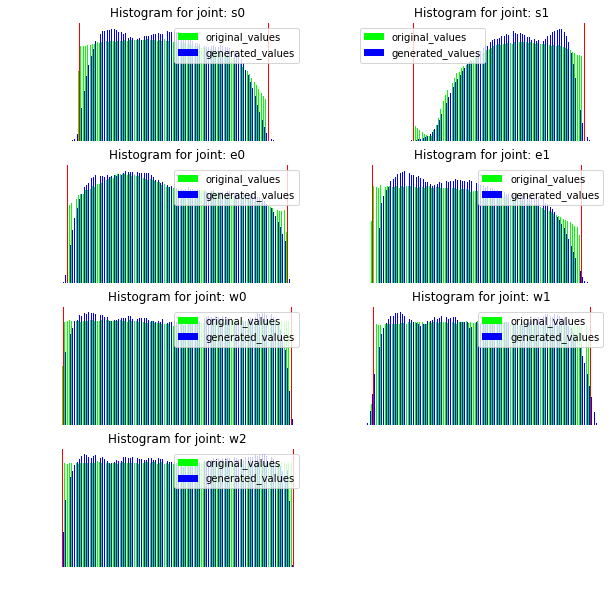

In [3]:
# Histogram plot for both generated and original data;

original_data = pd.read_csv(original_data_file_name, usecols=headers_w_collision)
original_data_free = original_data[original_data['inCollision'] == 1]

i = 1

fig = plt.figure(figsize=(10,10))
for joint_name in JOINT_NAMES:
    plt.subplot(4,2,i)
    header = 'right_' + joint_name
    original_joint_value = original_data_free[header]
    joint_value = data[header]
    i += 1
    plt.hist([original_joint_value, joint_value], density=True, histtype='bar', color=['lime','blue'],
             bins = 100, label=['original_values', 'generated_values'])
    plt.axvline(x=JOINT_LIMITS[joint_name][0], color='r', linewidth=1)
    plt.axvline(x=JOINT_LIMITS[joint_name][1], color='r', linewidth=1)
    plt.legend()
    
    # Add labels
    plt.title('Histogram for joint: %s' % joint_name)
    plt.xlabel('Joint configs')
    plt.ylabel('Frequency')
    plt.axis('off')
    
# plt.savefig(output_dir + 'combined_plot.png')
plt.show()

In [46]:
def countSpillover(headers, dataset, limits):
    """
    Check for number of spillovers that are beyong hardware limits;
    """
    counts = {}
    for joint in headers:
        joint_limit = limits[joint]
        joint_header = 'right_' + joint 
        joint_count = np.count_nonzero(np.logical_or(dataset[joint_header] < joint_limit[0], 
                                       dataset[joint_header] > joint_limit[1]))
        counts[joint_header] = joint_count / dataset.shape[0]
    return counts

def countSpilledProportion(headers, dataset, limits):
    values = np.zeros(dataset.shape[0])
    for joint in headers:
        joint_limit = limits[joint]
        joint_header = 'right_' + joint 
        values = np.logical_or(values, dataset[joint_header] < joint_limit[0])
        values = np.logical_or(values, dataset[joint_header] > joint_limit[1])
        
    rows = values.nonzero()[0]
    print("The joint limits are: %s" % limits)
    print("Examples of samples that are outside of hardware limits: ")
    print(dataset.iloc[rows].iloc[0:5,:])
    assert np.sum(dataset.iloc[rows][collisionKey] == np.zeros(len(rows))) == len(rows), \
    "Some out of range configurations are collision-free!"
    return np.count_nonzero(values) / dataset.shape[0]

In [47]:
# Analysis on the statistics on the data;
print("The number of configs in the dataset is: %s" % data.shape[0])
accuracy = data[data[collisionKey] == 1].shape[0] / data.shape[0]
print("The accuracy is: %s" % accuracy)

counts = countSpillover(JOINT_NAMES, data, JOINT_LIMITS)
print("The seperate proportion of spillovers are: %s" % counts)

total_proportion = countSpilledProportion(JOINT_NAMES, data, JOINT_LIMITS)
print("The total number of proportions is: %s" % total_proportion)

The number of configs in the dataset is: 1000000
The accuracy is: 0.919712
The seperate proportion of spillovers are: {'right_s0': 0.002748, 'right_s1': 0.002844, 'right_e0': 0.002591, 'right_e1': 0.001437, 'right_w0': 0.000786, 'right_w1': 0.009078, 'right_w2': 1.5e-05}
The joint limits are: {'s0': [-1.7016, 1.7016], 's1': [-2.147, 1.047], 'e0': [-3.0541, 3.0541], 'e1': [-0.05, 2.618], 'w0': [-3.059, 3.059], 'w1': [-1.5707, 2.094], 'w2': [-3.059, 3.059]}
Examples of samples that are outside of hardware limits: 
     right_s0  right_s1  right_e0  right_e1  right_w0  right_w1  right_w2  \
148 -0.998614  0.100753 -2.643043  2.317582 -2.548475  2.101864 -2.350806   
265 -0.850975  0.450942  2.204282  2.641915 -1.738026  1.506748 -2.087650   
321  0.119380  0.652077 -2.556760  0.896316 -3.074637  1.472278  1.210626   
389  0.106485  0.164253 -0.575688  2.033375 -1.346289 -1.609231  0.763605   
551  0.310911 -0.795655 -1.632119  1.410191  3.070905  1.191791  0.378551   

     inCollision  


AssertionError: Some out of range configurations are collision-free!